In [29]:
import numpy as np #Importing numpy 
from pymoo.algorithms.moo.nsga2 import NSGA2 #Importing NSGA 2 
from pymoo.core.problem import ElementwiseProblem #Importing problem
from pymoo.optimize import minimize #Importing objective
from pymoo.visualization.scatter import Scatter #Importing plots
import pandas as pd
import matplotlib.pyplot as plt #importing matplotlib plot
from pymoo.core.problem import Problem #Importing problem
from pymoo.problems.functional import FunctionalProblem #Importing problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from mpl_toolkits.mplot3d import Axes3D

In [30]:
class MyProblem(ElementwiseProblem):

    def __init__(self, vmin=42, vmax=201, fmin=0.05, fmax=0.33, dmin=0.5, dmax=2.5):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([vmin, fmin, dmin]),
                         xu=np.array([vmax, fmax, dmax]))
        self.i = 1

    def f1(self, v, f, d): #objective 1
        return 0.33349*(v**0.1480)*(f**0.4912)*(d**0.2898)

    def f2(self, v, f, d): #objective 2
        return -1000*v*f*d

    def g1(self, v, f,d): #constraint 1
        return (88 * (v**0.3156) * (f**0.2856)* (d**0.2250))-500

    def g2(self, v, f, d): #constraint 2
        return (18 * (v**(-0.0757)) * (f**0.7593) * (d**0.1912))-2

    def _evaluate(self, x, out, *args, **kwargs):
        v = x[0]
        f = x[1]
        d = x[2]
        f1 = self.f1(v, f, d)
        f2 = self.f2(v, f, d)
        g1 = self.g1(v, f, d)
        g2 = self.g2(v, f, d)
        self.i += 1
        out["F"] = [f1, f2]
        out["G"] = [g1, g2]
        
problem = MyProblem()


Overall Statistics :
 TW :
       Mean    Median       STD
0  0.193882  0.198317  0.044102
2  0.199251  0.202471  0.040786
4  0.195162  0.197940  0.041102
6  0.191462  0.194589  0.045725
8  0.191959  0.194148  0.044201
 MRR :
           Mean        Median           STD
1  18096.918631  17827.164979  11012.542765
3  19291.128742  19088.199483  10550.245411
5  18254.789393  17738.780111  10478.935011
7  17562.296040  16739.104934  11394.533120
9  17606.971554  16603.355002  11067.610980
           TW           MRR           V         F         D
0    0.266310  37425.377808  200.981094  0.074616  2.495619
1    0.108934   1052.173201   42.078348  0.050000  0.500099
2    0.262541  36320.966323  200.751916  0.072522  2.494758
3    0.118640   1843.821779   72.539133  0.050000  0.508365
4    0.195371  16909.104263  200.824681  0.050249  1.675628
..        ...           ...         ...       ...       ...
495  0.152670   6975.034755  200.867659  0.052815  0.657471
496  0.136380   4802.803188  1

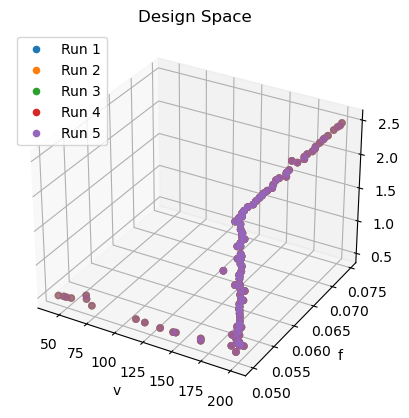

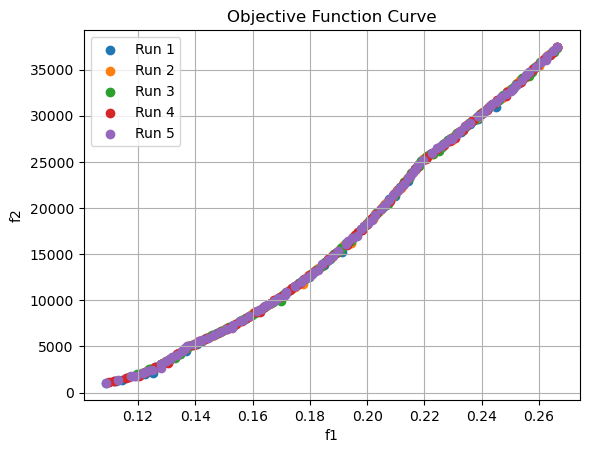

95% Confidence Interval for TW: (0.19055250032217327, 0.19813399805578932)
95% Confidence Interval for MRR: (17206.413864569142, 19118.42787902742)


In [33]:
def run_optimization(problem, algorithm, runs=5):
    all_results = []
    ind_stats = []
    for run in range(runs):
        result = minimize(problem, algorithm, ("n_gen", 500), verbose=False, seed=None, save_history=True, ignore_index=True)
        
        optimal_ip = pd.DataFrame(result.X, columns=['V', 'F', 'D'])
        optimal_op = pd.DataFrame(result.F, columns=['TW', 'MRR'])
        optimal_op['MRR'] = -optimal_op['MRR']  # Multiply by -1 to negate MRR

        resultdf = pd.concat([optimal_op, optimal_ip], axis=1, ignore_index=True)
        resultdf.columns = ['TW', 'MRR', 'V', 'F', 'D']
        
        #print(f"Run {run + 1}:")
        #print(round(result_df.head(100), 2))

        # Calculate and print statistics for each run
        run_mean = resultdf[['TW','MRR']].mean()
        run_median = resultdf[['TW','MRR']].median()
        run_std = resultdf[['TW','MRR']].std()
        indstat_df = pd.concat([run_mean, run_median, run_std], axis=1, ignore_index=True)
        indstat_df.columns = ['Mean', 'Median', 'STD']
        all_results.append(resultdf)
        ind_stats.append(indstat_df)                      
                             
    # Concatenate all DataFrames in the list to create a single DataFrame
    final_result = pd.concat(all_results, ignore_index=True)
    final_stat = pd.concat(ind_stats, ignore_index=True) 
    stats_tw =final_stat[final_stat.index % 2 == 0]
    stats_mrr=final_stat[final_stat.index % 2 != 0]
    print("Overall Statistics :")
    print(f" TW :\n{stats_tw}")
    print(f" MRR :\n{stats_mrr}")
    
    return final_result

pop_size = 100
algorithm = NSGA2(pop_size, n_offsprings=10,
                  sampling=FloatRandomSampling(),
                  crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(eta=20),
                  eliminate_duplicates=True)

# Run the optimization multiple times
final_result = run_optimization(problem, algorithm)
df=pd.DataFrame(final_result)
print(df)
ix=0
num_runs=5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for run in range(num_runs):  
    xval= df.iloc[ix:ix+pop_size,2]
    yval= df.iloc[ix:ix+pop_size,3]
    zval= df.iloc[ix:ix+pop_size,4]
    ax.scatter(xval, yval, zval, label=f'Run {run + 1}', marker='o')
    
ax.set_xlabel('v')
ax.set_ylabel('f')
ax.set_zlabel('d')
ax.set_title('Design Space')
ax.legend()
# Show the plot
plt.show() 

for run in range(num_runs):  
    
    x_values = df.iloc[ix:ix+pop_size,0]
    #print(x_values)
    
    # Evaluate the function with noise
    y_values = df.iloc[ix:ix+pop_size,1]
    #print(y_values)
    ix=ix+pop_size
    # Plot the run
    plt.scatter(x_values, y_values,label=f'Run {run + 1}')    

# Add labels and legend
plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Objective Function Curve')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
final_result_stats=df[['TW','MRR']]

from scipy.stats import t
confidence_interval_tw = t.interval(0.95, len(final_result_stats['TW']) - 1, final_result_stats['TW'].mean(), final_result_stats['TW'].sem())
confidence_interval_mrr = t.interval(0.95, len(final_result_stats['MRR']) - 1, final_result_stats['MRR'].mean(), final_result_stats['MRR'].sem())

# Print the confidence intervals
print("95% Confidence Interval for TW:", confidence_interval_tw)
print("95% Confidence Interval for MRR:", confidence_interval_mrr)